In [1]:
import pandas as pd
import requests
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import umap

/usr3/graduate/nramani/venvs/contlearn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
from torch_geometric.data.batch import Batch
from torch_geometric.data import Data
from torch.utils.data import Dataset

In [3]:
torch.manual_seed(2809)

In [4]:
scRNA_data = pd.read_csv('GSE200981_scRNAseq_processed.tsv', sep='\t')
scRNA_data.index = scRNA_data['Gene.names']
scRNA_data = scRNA_data.drop('Gene.names', axis=1)
len(scRNA_data)

26364

In [5]:
#Mapping string to protein names
string_api_url = "https://string-db.org/api"
output_format = "tsv-no-header"
method = "get_string_ids"

params = {

    "identifiers" : "\r".join(list(scRNA_data.index)), # your protein list
    "limit": 1,
    "echo_query": 1,
    "species" : 9606, # species NCBI identifier 
    "caller_identity" : "www.awesome_app.org" # your app name

}

request_url = "/".join([string_api_url, output_format, method])

results = requests.post(request_url, data=params)


protein_2_string = dict()
string_2_protein = dict()

for line in results.text.strip().split("\n"):
    l = line.split("\t")
    protein_identifier, string_identifier = l[0], l[2]
    protein_2_string[protein_identifier] = string_identifier
    string_2_protein[string_identifier] = protein_identifier

In [6]:
scRNA_data = scRNA_data.loc[list(protein_2_string.keys())]
scRNA_data

,V1_T0,V2_T0,V3_T0,V4_T0,V5_T0,V6_T0,V7_T0,V8_T0,V9_T0,V10_T0,...,V247_T7,V248_T7,V249_T7,V250_T7,V251_T7,V252_T7,V253_T7,V254_T7,V255_T7,V256_T7
Gene.names,,,,,,,,,,,,,,,,,,,,,
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAZ1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DAZ3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DAZ2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
import gc
torch.cuda.empty_cache()
gc.collect()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [8]:
device

device(type='cuda')

In [9]:
def get_all_protein_pairs(protein_list):
    protein_pairs = []
    for i in range(len(protein_list)):
        protein1 = protein_list[i]
        for j in range(i+1, len(protein_list)):
            protein2 = protein_list[j]
        
            protein_pairs.append((protein1, protein2))
            
    return protein_pairs

class Contrastive_Dataset(Dataset):
    def __init__(self, scRNA_data, string_2_protein, batch_size):
        self.counter = 0
        self.e_counter = 0
        self.m_counter = 0
        self.batch_size = batch_size
        filename = '9606.protein.links.v12.0.txt'

        file = open(filename, 'r')
        lines = file.readlines()
        lines.pop(0)

        string_2_index = dict()
        counter = 0
        for string_id in string_2_protein:
            string_2_index[string_id] = counter
            counter += 1

        list_network = list()
        
        self.e_nodes = list()
        self.m_nodes = list()

        print('Getting network tensor...')
        for line in tqdm(lines):
            line = line.strip().split(' ')

            if int(line[2]) >= 999:

                try:
                    id1 = string_2_index[line[0]]
                    id2 = string_2_index[line[1]]
                    list_network.append([id1, id2])
                    list_network.append([id2, id1])

                except KeyError:
                    continue

        print('Getting node features tensor...')
        T0_column_vals = [column for column in scRNA_data.columns if 'T0' in column]
        T8_column_vals = [column for column in scRNA_data.columns if 'T7' in column]
        
        proteins = set([string_2_protein[string_id] for string_id in string_2_index])
        
        for column in T0_column_vals:   
            self.e_nodes.append(torch.tensor([scRNA_data.loc[protein, column] for protein in proteins], dtype=torch.float32).to(device))
                                        
        for column in T8_column_vals:
            self.m_nodes.append(torch.tensor([scRNA_data.loc[protein, column] for protein in proteins], dtype=torch.float32).to(device))
        
        self.edge_index = torch.tensor(list_network).t().contiguous()
        self.edge_index = self.edge_index.to(device)
        
        self.e_nodes = [i.view(len(i), 1) for i in self.e_nodes]
        self.m_nodes = [i.view(len(i), 1) for i in self.m_nodes]
    
    def __getitem__(self, idx):
        return self.e_nodes[idx], self.m_nodes[idx], self.edge_index
            
    def get_e_nodes(self):
        return self.e_nodes
    
    def get_m_nodes(self):
        return self.m_nodes#[0:10]
    
    def get_edge_index(self):
        return self.edge_index

    def shuffle(self):
        random.shuffle(self.e_nodes)
        random.shuffle(self.m_nodes)

    def __len__(self):
        return min(len(self.e_nodes), len(self.m_nodes))

In [10]:
def graph_collate_fn(batch):
    m_node_features = []
    e_node_features = []
    graph_list = []
    counter = 0
    batch_size = len(batch)
    
    for ex in batch:
        e_node, m_node, graph = ex
        num_nodes = e_node.shape[0]
        m_node_features.append(m_node)
        e_node_features.append(e_node)

    for i in range(batch_size):
        graph_list.append(graph + num_nodes*i)
    graphs_2 = graph_list[0:2]

    e_node_features = torch.stack(e_node_features, dim=0)
    e_node_features = torch.reshape(e_node_features, (e_node_features.shape[0]*e_node_features.shape[1], e_node_features.shape[2]))
    
    graphs = torch.cat(graph_list, 1)
    graphs_2 = torch.cat(graphs_2, 1)

    m_node_features = torch.stack(m_node_features, dim=0)
    m_node_features = torch.reshape(m_node_features, (m_node_features.shape[0]*m_node_features.shape[1], m_node_features.shape[2]))
    
    return e_node_features, m_node_features, graphs_2, graphs

In [11]:
batch_size = 20
contrastive_dataset = Contrastive_Dataset(scRNA_data, string_2_protein, batch_size)

Getting network tensor...


100%|██████████| 13715404/13715404 [00:08<00:00, 1614045.11it/s]


Getting node features tensor...


In [12]:
#contrastive_dataloader = DataLoader(contrastive_dataset, batch_size=batch_size, shuffle=True, collate_fn=graph_collate_fn)

In [13]:
def cosine_similarity(x1, x2, temp):
    return (torch.dot(x1.reshape(x1.shape[1]), x2.reshape(x2.shape[1]))/(torch.norm(x1)*torch.norm(x2)))/temp
    
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        self.temp = 1
    
    def forward(self, zn, zd):
        zi = zn[0, :, :]
        zj = zn[1, :, :].detach()
        num = torch.exp(cosine_similarity(zi, zj, self.temp))
        #print('Numerator')
        #print(num)

        #with torch.no_grad():
        denom = sum([torch.exp(cosine_similarity(zi, zd[i, :, :].detach(), self.temp)) for i in range(zd.shape[0])])
        #print('Denominator')
        #print(denom)
        return torch.multiply(torch.log(torch.divide(num, denom)), -1)

In [14]:
def train_model(epochs, dataset, gat, mlp, optimizer):
    torch.cuda.empty_cache()
    criterion = ContrastiveLoss()
    plot_losses = []
    for _ in tqdm(range(epochs)):
        dataset.shuffle()
        dataloader = DataLoader(dataset, batch_size=10, shuffle=False, collate_fn=graph_collate_fn)
        torch.cuda.empty_cache()
        
        for batch in dataloader:
            batch_losses = []
            e_nodes, m_nodes, graphs_2, graphs = batch
            batch_size = e_nodes.shape[0]//18840
            e_nodes_unstacked = torch.reshape(e_nodes, (batch_size, 1, -1))

            zd = gat(m_nodes, graphs)
            zd = mlp(zd)

            all_losses = []

            for i in range(e_nodes_unstacked.shape[0]):
                xi = e_nodes_unstacked[i]
                #print(xi)
                for j in range(e_nodes_unstacked.shape[0]):
                    if i == j: continue
                    xj = e_nodes_unstacked[j]
                    xn = torch.stack([xi, xj], dim=0)
                    xn = torch.reshape(xn, (xn.shape[0]*xn.shape[2], xn.shape[1]))
                    zn = gat(xn, graphs_2)
                    zn = mlp(zn)

                    loss = criterion(zn, zd)
                    #print(loss)
                    all_losses.append(loss)
                    
            #final_loss = sum(all_losses)/len(all_losses)
            #batch_losses.append(final_loss.item())
            #print(final_loss)
            #final_loss.backward()
            #optimizer.step()
            #final_loss.detach()

            m_nodes_unstacked = torch.reshape(m_nodes, (batch_size, 1, -1))

            zd = gat(e_nodes, graphs)
            zd = mlp(zd)

            #all_losses = []
            for i in range(m_nodes_unstacked.shape[0]):
                xi = m_nodes_unstacked[i]
                #print(xi)
                for j in range(m_nodes_unstacked.shape[0]):
                    if i == j: continue

                    xj = m_nodes_unstacked[j]
                    xn = torch.stack([xi, xj], dim=0)
                    xn = torch.reshape(xn, (xn.shape[0]*xn.shape[2], xn.shape[1]))
                    zn = gat(xn, graphs_2)
                    zn = mlp(zn)

                    loss = criterion(zn, zd)
                    all_losses.append(loss)
                    
            final_loss = sum(all_losses)/len(all_losses)
            batch_losses.append(final_loss.item())
            #print(final_loss)
            final_loss.backward()
            optimizer.step()
            #final_loss.detach()
        plot_losses.append(sum(batch_losses)/len(batch_losses)) 
        print(plot_losses)
    return plot_losses

In [15]:
class GAT_Contrast(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()

        self.conv1 = GATConv(in_channels, hidden_channels, heads, dropout = 0.6)
        #self.conv2 = GATConv(hidden_channels*heads, out_channels, heads, dropout=0.6)
        self.num_nodes = 18840
        self.output_layer = nn.Linear(self.num_nodes*hidden_channels*heads, out_channels)
        #self.columns = out_channels*heads

    def forward(self, x, edge_index):
        batch_size = x.shape[0]//self.num_nodes
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = torch.reshape(x, (batch_size, 1, -1))

        x = self.output_layer(x)
        x = F.relu(x)
        return x

class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        self.linear1 = nn.Linear(in_channels, hidden_channels)
        self.linear2 = nn.Linear(hidden_channels, out_channels)
        self.num_nodes = 18840

    def forward(self, x):
        #batch_size = x.shape[0]//self.num_nodes
        #x = torch.reshape(x, (batch_size, 1, -1))
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        return x

In [16]:
import torch_geometric.utils
from torch_geometric.nn import GATConv

def GAT_contrast_train(gat, mlp, dataset, epochs, num_nodes, lr = 1e-6, weight_decay = 5e-4, temp=0.05):
    torch.cuda.empty_cache()
    params = list(gat.parameters()) + list(mlp.parameters())
    optimizer = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
    criterion = ContrastiveLoss()
    gat.train()
    mlp.train()
    optimizer.zero_grad()

    losses = train_model(epochs, dataset, gat, mlp, optimizer)
    return losses

In [17]:
#Need to put in tensor batches again
gat_contrast = GAT_Contrast(1, 8, 64, 2).to(device)
mlp_contrast = MLP(64, 32, 16).to(device)
#gat_contrast = torch.load('gat_contrast.pt', weights_only=False)
#mlp_contrast = torch.load('mlp_contrast.pt', weights_only=False)

In [18]:
losses = GAT_contrast_train(gat_contrast, mlp_contrast, contrastive_dataset, 100, scRNA_data.shape[0])

  1%|          | 1/100 [00:29<47:51, 29.00s/it]

[1.7785615921020508]


  2%|▏         | 2/100 [00:57<47:18, 28.97s/it]

[1.7785615921020508, 1.573452353477478]


  3%|▎         | 3/100 [01:26<46:43, 28.90s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827]


  4%|▍         | 4/100 [01:55<46:00, 28.75s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272]


  5%|▌         | 5/100 [02:24<45:32, 28.76s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876]


  6%|▌         | 6/100 [02:52<45:04, 28.77s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155]


  7%|▋         | 7/100 [03:21<44:36, 28.78s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814]


  8%|▊         | 8/100 [03:50<44:08, 28.79s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225]


  9%|▉         | 9/100 [04:19<43:41, 28.80s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669]


 10%|█         | 10/100 [04:47<43:09, 28.77s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563]


 11%|█         | 11/100 [05:16<42:37, 28.74s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514]


 12%|█▏        | 12/100 [05:45<42:07, 28.72s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291]


 13%|█▎        | 13/100 [06:13<41:34, 28.68s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192]


 14%|█▍        | 14/100 [06:42<41:05, 28.67s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647]


 15%|█▌        | 15/100 [07:11<40:33, 28.63s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705]


 16%|█▌        | 16/100 [07:39<39:56, 28.52s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399]


 17%|█▋        | 17/100 [08:07<39:26, 28.51s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323]


 18%|█▊        | 18/100 [08:36<38:56, 28.49s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936]


 19%|█▉        | 19/100 [09:04<38:21, 28.41s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029]


 20%|██        | 20/100 [09:32<37:44, 28.30s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853]


 21%|██        | 21/100 [10:00<37:12, 28.26s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731]


 22%|██▏       | 22/100 [10:28<36:39, 28.20s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914]


 23%|██▎       | 23/100 [10:56<36:09, 28.18s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728]


 24%|██▍       | 24/100 [11:24<35:35, 28.10s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649]


 25%|██▌       | 25/100 [11:52<35:06, 28.09s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021]


 26%|██▌       | 26/100 [12:20<34:38, 28.09s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806]


 27%|██▋       | 27/100 [12:49<34:09, 28.07s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099]


 28%|██▊       | 28/100 [13:17<33:41, 28.07s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346]


 29%|██▉       | 29/100 [13:44<33:08, 28.01s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402]


 30%|███       | 30/100 [14:13<32:42, 28.03s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242]


 31%|███       | 31/100 [14:41<32:15, 28.05s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974]


 32%|███▏      | 32/100 [15:09<31:45, 28.02s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623]


 33%|███▎      | 33/100 [15:37<31:18, 28.03s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961]


 34%|███▍      | 34/100 [16:05<30:49, 28.02s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135]


 35%|███▌      | 35/100 [16:33<30:18, 27.98s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319]


 36%|███▌      | 36/100 [17:00<29:50, 27.98s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579]


 37%|███▋      | 37/100 [17:29<29:23, 27.99s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802]


 38%|███▊      | 38/100 [17:57<28:57, 28.03s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084]


 39%|███▉      | 39/100 [18:25<28:28, 28.01s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165]


 40%|████      | 40/100 [18:53<28:00, 28.01s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094]


 41%|████      | 41/100 [19:21<27:32, 28.02s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427]


 42%|████▏     | 42/100 [19:49<27:04, 28.02s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668]


 43%|████▎     | 43/100 [20:16<26:33, 27.95s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212]


 44%|████▍     | 44/100 [20:44<26:06, 27.97s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598]


 45%|████▌     | 45/100 [21:12<25:38, 27.97s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645]


 46%|████▌     | 46/100 [21:40<25:11, 27.99s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463]


 47%|████▋     | 47/100 [22:08<24:42, 27.97s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224]


 48%|████▊     | 48/100 [22:36<24:12, 27.93s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883]


 49%|████▉     | 49/100 [23:04<23:45, 27.94s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582]


 50%|█████     | 50/100 [23:32<23:18, 27.97s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795]


 51%|█████     | 51/100 [24:00<22:50, 27.97s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 52%|█████▏    | 52/100 [24:28<22:22, 27.97s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 53%|█████▎    | 53/100 [24:56<21:52, 27.93s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 54%|█████▍    | 54/100 [25:24<21:24, 27.93s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 55%|█████▌    | 55/100 [25:52<20:58, 27.96s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 56%|█████▌    | 56/100 [26:20<20:30, 27.97s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 57%|█████▋    | 57/100 [26:48<20:04, 28.01s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 58%|█████▊    | 58/100 [27:16<19:35, 28.00s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 59%|█████▉    | 59/100 [27:44<19:06, 27.96s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 60%|██████    | 60/100 [28:12<18:38, 27.97s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 61%|██████    | 61/100 [28:40<18:11, 27.97s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 62%|██████▏   | 62/100 [29:08<17:42, 27.97s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 63%|██████▎   | 63/100 [29:36<17:14, 27.96s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 64%|██████▍   | 64/100 [30:04<16:46, 27.96s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 65%|██████▌   | 65/100 [30:32<16:18, 27.95s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 66%|██████▌   | 66/100 [31:00<15:50, 27.96s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 67%|██████▋   | 67/100 [31:27<15:21, 27.92s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 68%|██████▊   | 68/100 [31:55<14:53, 27.93s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 69%|██████▉   | 69/100 [32:23<14:26, 27.94s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 70%|███████   | 70/100 [32:51<13:58, 27.96s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 71%|███████   | 71/100 [33:19<13:30, 27.94s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 72%|███████▏  | 72/100 [33:47<13:00, 27.89s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 73%|███████▎  | 73/100 [34:15<12:33, 27.90s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 74%|███████▍  | 74/100 [34:43<12:05, 27.90s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 75%|███████▌  | 75/100 [35:11<11:37, 27.91s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 76%|███████▌  | 76/100 [35:39<11:09, 27.91s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 77%|███████▋  | 77/100 [36:07<10:42, 27.92s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 78%|███████▊  | 78/100 [36:34<10:13, 27.88s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 79%|███████▉  | 79/100 [37:02<09:45, 27.90s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 80%|████████  | 80/100 [37:30<09:18, 27.90s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 81%|████████  | 81/100 [37:58<08:50, 27.90s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 82%|████████▏ | 82/100 [38:26<08:22, 27.92s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 83%|████████▎ | 83/100 [38:54<07:54, 27.93s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 84%|████████▍ | 84/100 [39:22<07:27, 27.96s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 85%|████████▌ | 85/100 [39:50<06:59, 27.94s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 86%|████████▌ | 86/100 [40:18<06:30, 27.87s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 87%|████████▋ | 87/100 [40:46<06:02, 27.90s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 88%|████████▊ | 88/100 [41:14<05:34, 27.90s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 89%|████████▉ | 89/100 [41:42<05:07, 27.94s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 90%|█████████ | 90/100 [42:10<04:39, 27.99s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 91%|█████████ | 91/100 [42:38<04:11, 27.91s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 92%|█████████▏| 92/100 [43:05<03:43, 27.92s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 93%|█████████▎| 93/100 [43:33<03:15, 27.92s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 94%|█████████▍| 94/100 [44:01<02:47, 27.92s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 95%|█████████▌| 95/100 [44:29<02:19, 27.91s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 96%|█████████▌| 96/100 [44:57<01:51, 27.86s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 97%|█████████▋| 97/100 [45:25<01:23, 27.87s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 98%|█████████▊| 98/100 [45:53<00:55, 27.88s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

 99%|█████████▉| 99/100 [46:21<00:27, 27.92s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

100%|██████████| 100/100 [46:49<00:00, 28.09s/it]

[1.7785615921020508, 1.573452353477478, 1.3360084295272827, 1.297092080116272, 1.1836315393447876, 0.908219039440155, 0.9439043402671814, 1.000877022743225, 0.8507300615310669, 0.860204815864563, 0.8277080059051514, 0.836550235748291, 0.8232596516609192, 0.822818398475647, 0.8205313086509705, 0.8082567453384399, 0.8204764127731323, 0.8369529247283936, 0.9632613658905029, 0.8248104453086853, 0.8267853856086731, 0.8099069595336914, 0.8066677451133728, 0.8082872629165649, 0.7982861995697021, 0.7980942130088806, 0.8267039656639099, 0.8122360706329346, 0.7999359965324402, 0.7955045700073242, 0.7939128279685974, 0.8032538890838623, 0.7971944808959961, 0.7939377427101135, 0.8003667593002319, 0.7972696423530579, 0.7949523329734802, 0.7987475991249084, 0.7947927713394165, 0.7952537536621094, 0.79432213306427, 0.8023982048034668, 0.7939171195030212, 0.7983306050300598, 0.7978291511535645, 0.7929630875587463, 0.7938212752342224, 0.7930727005004883, 0.7949263453483582, 0.7947641015052795, 0.794343

In [19]:
"""plt.plot([i for i in range(len(losses))], losses)
plt.xlabel('Epochs')
plt.ylabel('Contrastive Loss')
plt.show()"""

"plt.plot([i for i in range(len(losses))], losses)\nplt.xlabel('Epochs')\nplt.ylabel('Contrastive Loss')\nplt.show()"

In [20]:
torch.save(gat_contrast, 'gat_contrast.pt')
torch.save(mlp_contrast, 'mlp_contrast.pt')
#gat_contrast = torch.load('gat_contrast.pt', weights_only=False)
#mlp_contrast = torch.load('mlp_contrast.pt', weights_only=False)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [22]:
def RFC_test(model, dataset):
    model.eval()
    
    e_nodes = dataset.get_e_nodes()
    m_nodes = dataset.get_m_nodes()
    edge_index = dataset.get_edge_index()

    x = e_nodes + m_nodes
    x = [model(i, edge_index).reshape(-1).detach().cpu().numpy() for i in x]
    y = [0 for _ in range(len(e_nodes))] + [1 for _ in range(len(m_nodes))]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
 
    rf = RandomForestClassifier()
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)
    return rf

In [23]:
rf = RFC_test(gat_contrast, contrastive_dataset)

1.0


In [24]:
def test_timepoint(t, scRNA_data, model, rfc, edge_index, string_2_protein):
    t_nodes = list()
    T_column_vals = [column for column in scRNA_data.columns if t in column]
    filename = '9606.protein.links.v12.0.txt'

    file = open(filename, 'r')
    lines = file.readlines()
    lines.pop(0)

    string_2_index = dict()
    counter = 0
    for string_id in string_2_protein:
        string_2_index[string_id] = counter
        counter += 1
        
    proteins = set([string_2_protein[string_id] for string_id in string_2_index])
    for column in T_column_vals:   
        t_nodes.append(torch.tensor([scRNA_data.loc[protein, column] for protein in proteins], dtype=torch.float32).to(device))

    t_nodes = [i.view(len(i), 1) for i in t_nodes]
    pos = 0
    for tens in t_nodes:
        output = model(tens, edge_index).reshape(1, -1).detach().cpu().numpy()
        pos += rfc.predict(output).item()
        #print(pos)
        #print(type(pos))
    return pos/len(t_nodes)

In [25]:
edge_index = contrastive_dataset.get_edge_index()
test_timepoint('T1', scRNA_data, gat_contrast, rf, edge_index, string_2_protein)

0.075

In [26]:
test_timepoint('T2', scRNA_data, gat_contrast, rf, edge_index, string_2_protein)

0.3088803088803089

In [27]:
test_timepoint('T3', scRNA_data, gat_contrast, rf, edge_index, string_2_protein)

0.8309178743961353

In [28]:
test_timepoint('T4', scRNA_data, gat_contrast, rf, edge_index, string_2_protein)

0.9552238805970149

In [29]:
test_timepoint('T5', scRNA_data, gat_contrast, rf, edge_index, string_2_protein)

0.9585062240663901

In [30]:
test_timepoint('T6', scRNA_data, gat_contrast, rf, edge_index, string_2_protein)

0.981549815498155

- look at latent space representations of feature representations
- create a UMAP and color by days

In [31]:
import numpy as np

def get_t_nodes(t):
    t_nodes = list()
    T_column_vals = [column for column in scRNA_data.columns if t in column]
    filename = '9606.protein.links.v12.0.txt'

    file = open(filename, 'r')
    lines = file.readlines()
    lines.pop(0)

    string_2_index = dict()
    counter = 0
    for string_id in string_2_protein:
        string_2_index[string_id] = counter
        counter += 1
        
    proteins = set([string_2_protein[string_id] for string_id in string_2_index])
    for column in T_column_vals:   
        t_nodes.append(torch.tensor([scRNA_data.loc[protein, column] for protein in proteins], dtype=torch.float32).to(device))

    t_nodes = [i.view(len(i), 1) for i in t_nodes]
    t_nodes = [gat_contrast(i, edge_index).reshape(-1).detach().cpu().numpy() for i in t_nodes]

    umap_nodes = np.stack(t_nodes, axis=0)
    return umap_nodes

In [32]:
timepoints = ['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']
t_nodes = dict()
for t in timepoints:
    t_nodes[t] = get_t_nodes(t)

In [33]:
import numpy as np
color_map = {'T0':'blue', 'T1':'orange', 'T2':'green', 'T3':'red', 'T4':'purple', 'T5':'brown', 'T6':'pink', 'T7':'gray'}
fit = umap.UMAP(random_state=42)
nodes = np.vstack(list(t_nodes.values()))
u = fit.fit_transform(nodes)
colors = [
    color_map[t]
    for t in timepoints
        for _ in range(t_nodes[t].shape[0])]

/usr3/graduate/nramani/venvs/contlearn/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


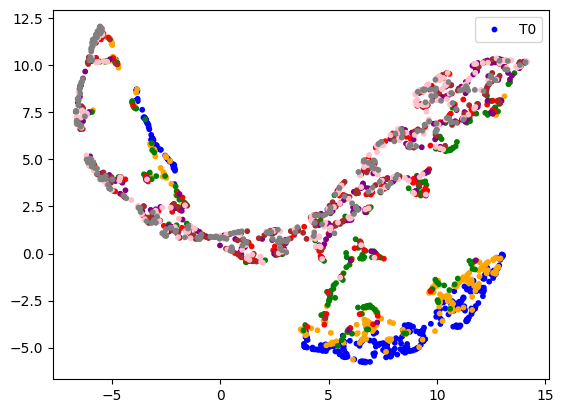

In [34]:
plt.scatter(u[:,0], u[:,1], c=colors, s=10)
plt.legend(['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'])
plt.show()

In [35]:
color_map = {'T0':'blue', 'T1':'orange', 'T2':'green', 'T3':'red', 'T4':'purple', 'T5':'brown', 'T6':'pink', 'T7':'gray'}

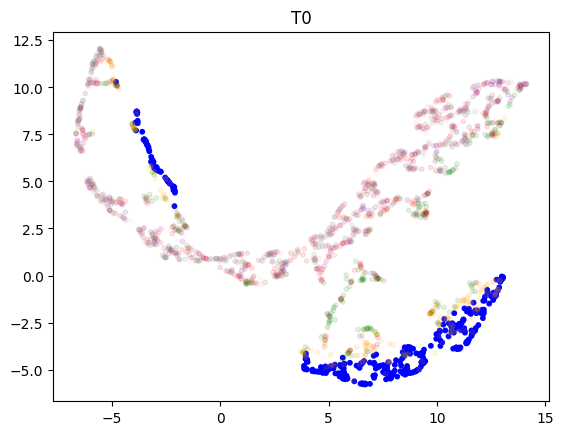

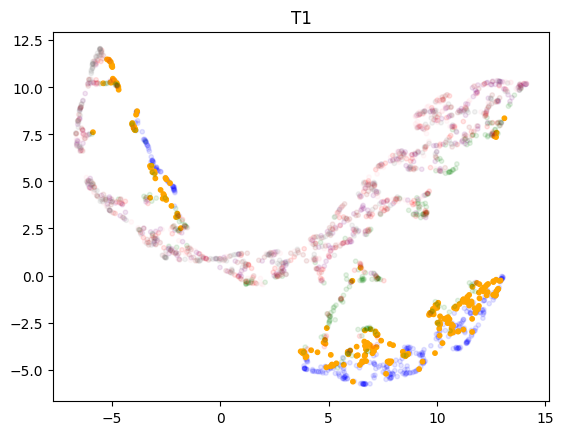

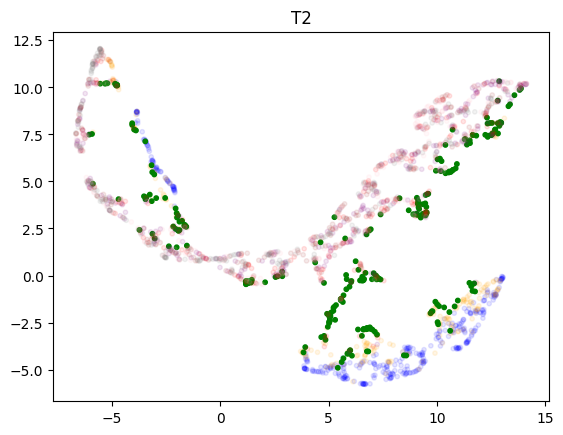

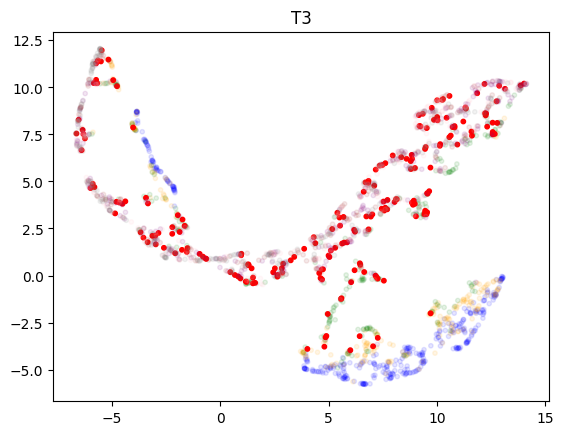

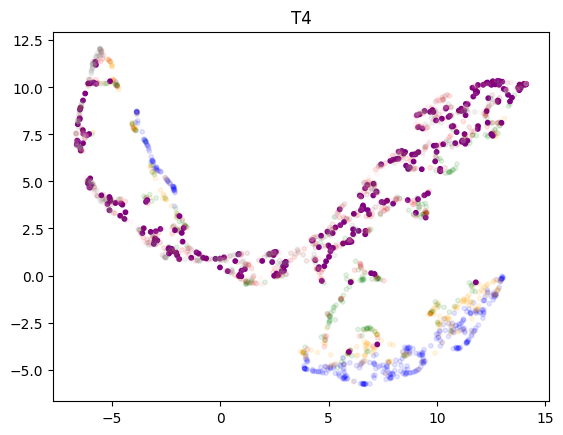

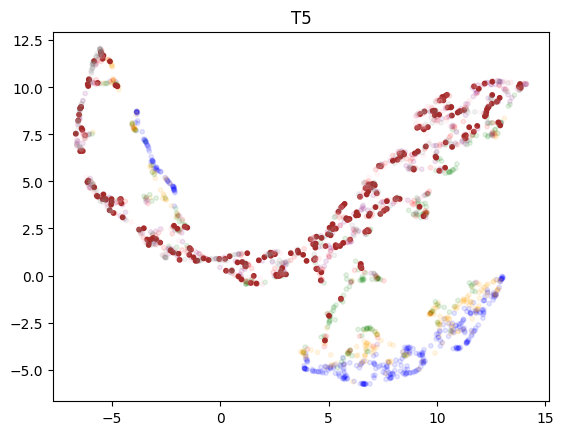

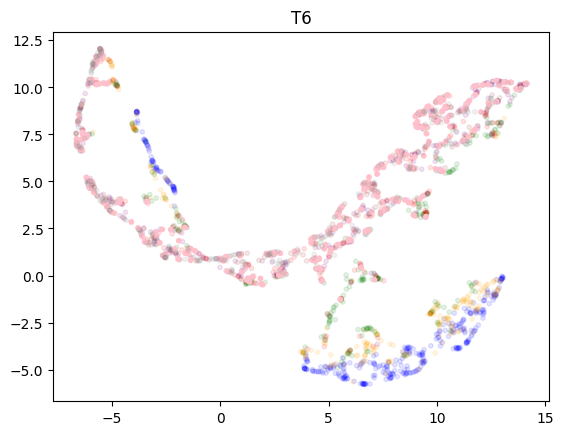

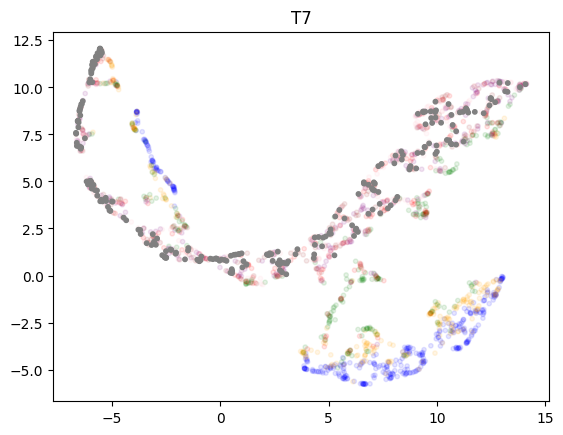

In [36]:
for t1 in timepoints:
    alpha_map = {'T0':0.10, 'T1':0.10, 'T2':0.10, 'T3':0.10, 'T4':0.10, 'T5':0.10, 'T6':0.10, 'T7':0.10}
    alpha_map[t1] = 1.0

    alphas = [
        alpha_map[t]
        for t in timepoints
            for _ in range(t_nodes[t].shape[0])]
    plt.title(t1)
    plt.scatter(u[:,0], u[:,1], c=colors, alpha=alphas, s=10)
    plt.show()
        

In [37]:
from sklearn.cluster import KMeans

In [38]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

nodes_scaled = sc.fit_transform(nodes)

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

x = pca.fit_transform(nodes_scaled)

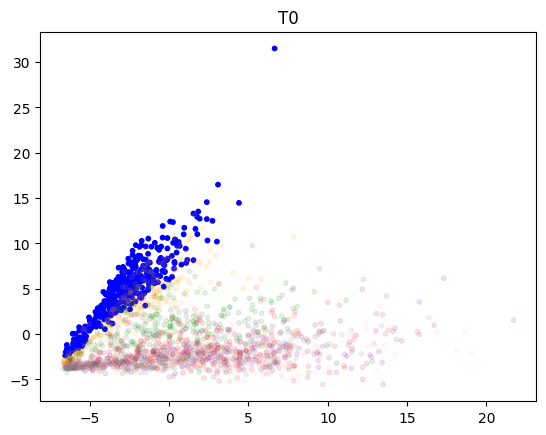

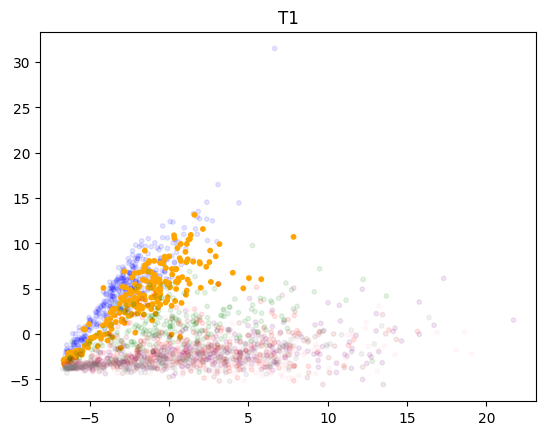

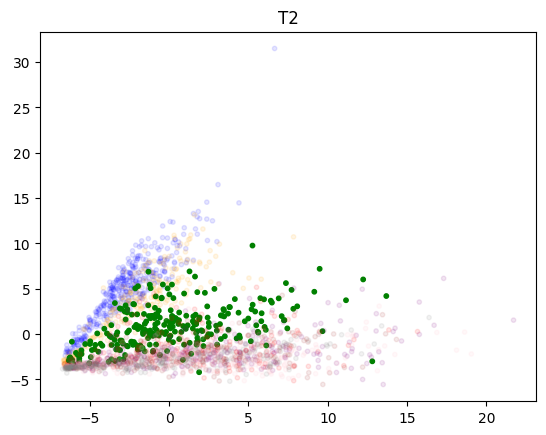

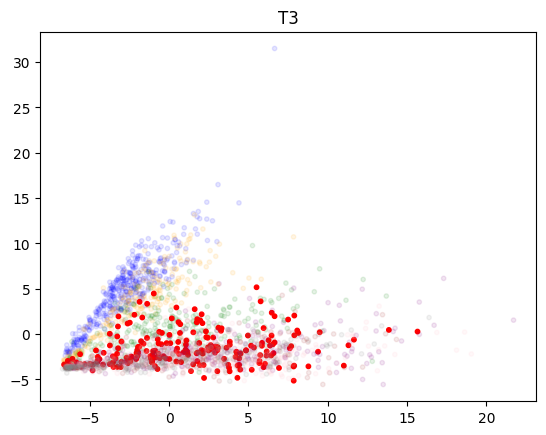

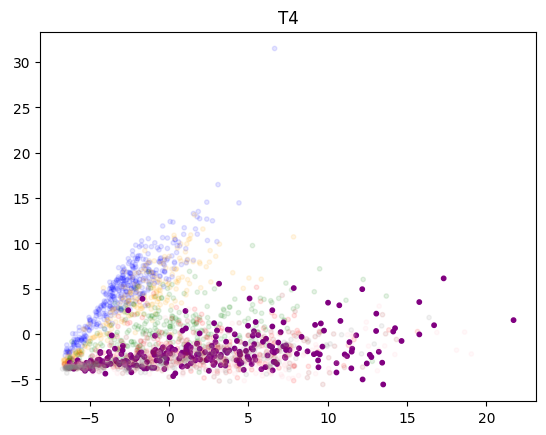

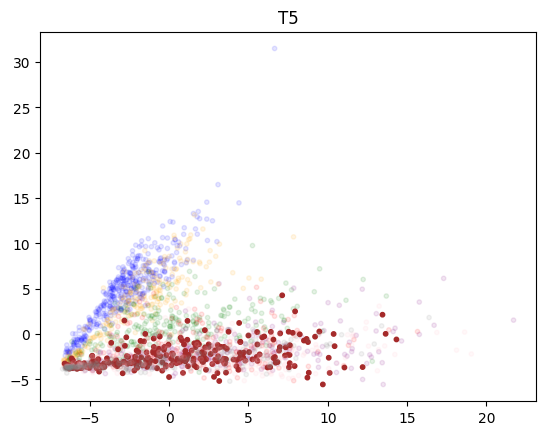

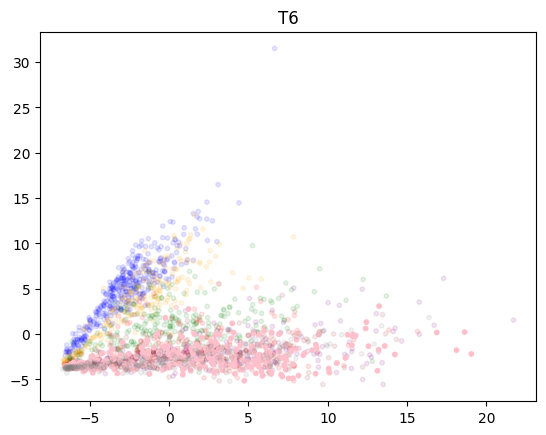

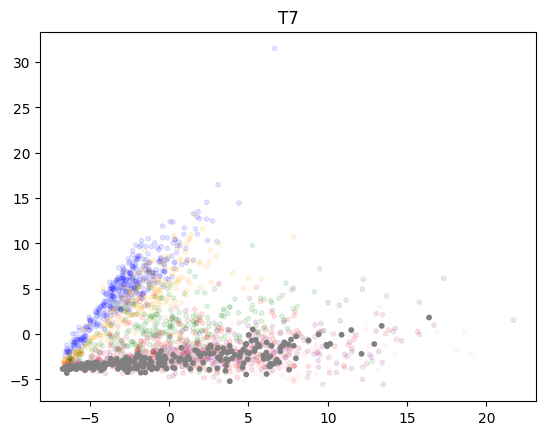

In [40]:
for t1 in timepoints:
    alpha_map = {'T0':0.10, 'T1':0.10, 'T2':0.10, 'T3':0.10, 'T4':0.10, 'T5':0.10, 'T6':0.10, 'T7':0.10}
    alpha_map[t1] = 1.0

    alphas = [
        alpha_map[t]
        for t in timepoints
            for _ in range(t_nodes[t].shape[0])]
    plt.title(t1)
    plt.scatter([i[0] for i in x], [i[1] for i in x], c=colors, alpha=alphas, s=10)
    plt.show()
        
#plt.scatter([i[0] for i in x], [i[1] for i in x], c=colors, s=10)
#plt.show()

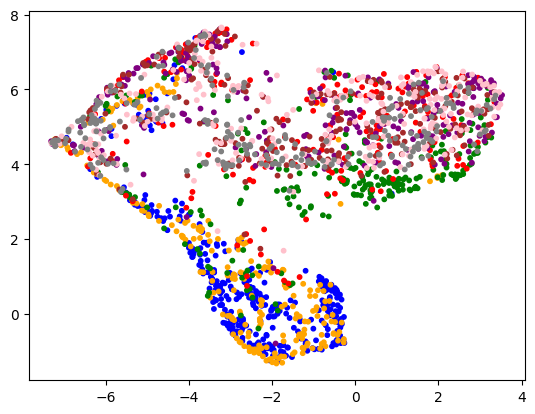

In [41]:
scRNA_vecs = dict()
for t in timepoints:
    scRNA_vecs[t] = np.transpose(scRNA_data.loc[:, [cell for cell in scRNA_data.columns if t in cell]].to_numpy())

nodes = np.vstack(list(scRNA_vecs.values()))
u = fit.fit_transform(nodes)
colors = [
    color_map[t]
    for t in timepoints
        for _ in range(t_nodes[t].shape[0])]

plt.scatter(u[:,0], u[:,1], c=colors, s=10)
#plt.legend(['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'])
plt.show()

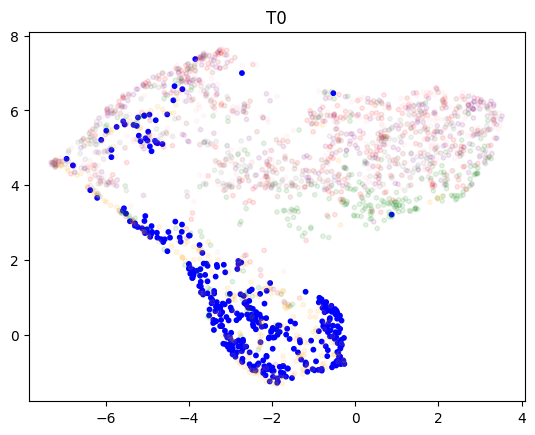

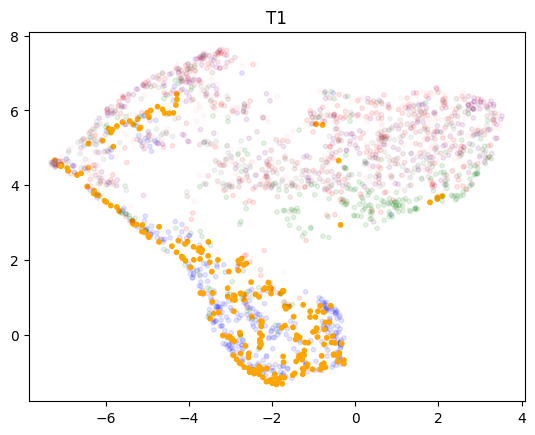

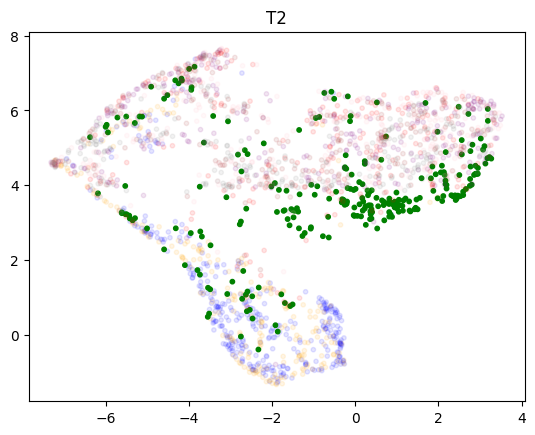

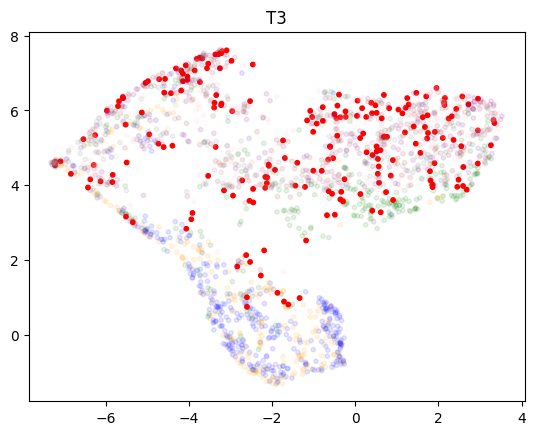

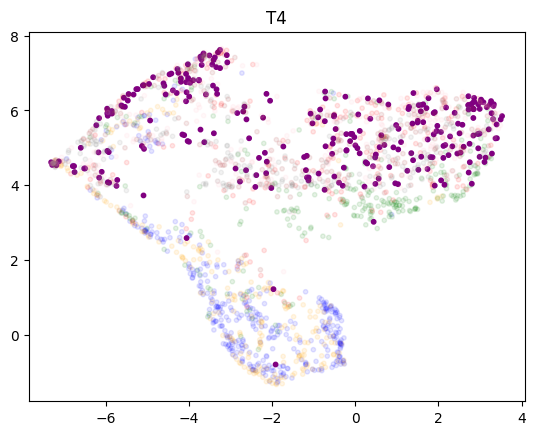

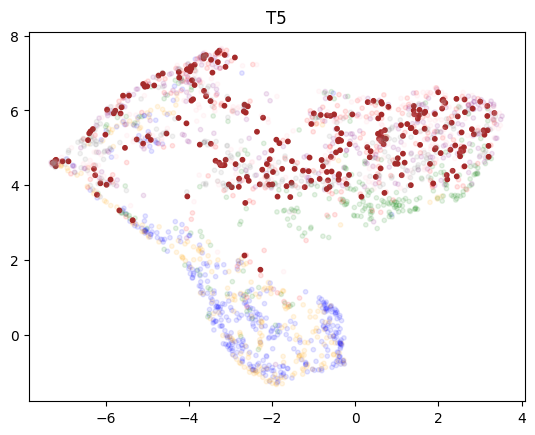

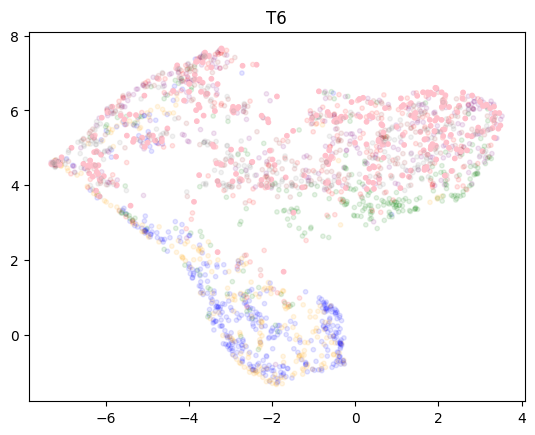

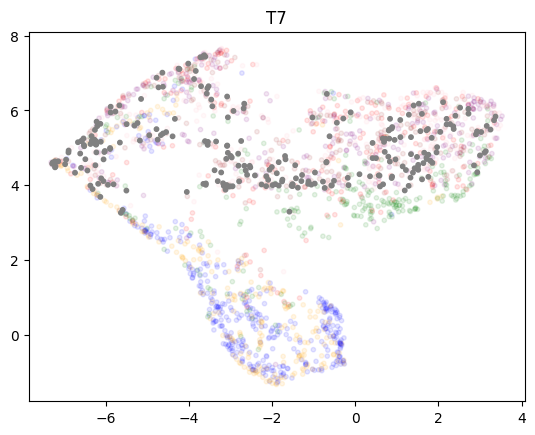

In [42]:
for t1 in timepoints:
    alpha_map = {'T0':0.10, 'T1':0.10, 'T2':0.10, 'T3':0.10, 'T4':0.10, 'T5':0.10, 'T6':0.10, 'T7':0.10}
    alpha_map[t1] = 1.0

    alphas = [
        alpha_map[t]
        for t in timepoints
            for _ in range(t_nodes[t].shape[0])]
    plt.title(t1)
    plt.scatter(u[:,0], u[:,1], c=colors, alpha=alphas, s=10)
    plt.show()
        

# Making Monocle Files

In [55]:
expression_matrix = scRNA_data.to_numpy()
np.savetxt('expression_matrix.txt', expression_matrix)

In [59]:
cell_metadata = dict()
for cell in scRNA_data.columns:
    cell_metadata[cell] = cell.split('_')[1]

cell_metadata = pd.DataFrame(cell_metadata.items(), columns=['cells', 'timepoint'])
cell_metadata = cell_metadata.set_index('cells')
cell_metadata.to_csv('cell_metadata.csv')

In [61]:
gene_attributes = {'gene': list(scRNA_data.index), 'gene_short_name': list(scRNA_data.index)}
gene_attributes = pd.DataFrame(data = gene_attributes)
gene_attributes = gene_attributes.set_index('gene')
gene_attributes.to_csv('gene_attributes.csv')

In [48]:
gene_attributes

,gene_attributes
gene,
OR4F5,OR4F5
OR4F3,OR4F3
OR4F29,OR4F29
OR4F16,OR4F16
SAMD11,SAMD11
...,...
DAZ1,DAZ1
DAZ3,DAZ3
DAZ2,DAZ2
